In [1]:
gpu=7
CUDA_VISIBLE_DEVICES=gpu
!nvidia-smi

Mon Nov 29 12:13:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   24C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   22C    P8     7W / 250W |    691MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

# import osa
import shutil

In [3]:
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import models
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
# import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = gpu

True
11721506816
0


In [4]:
train_df=pd.read_csv("/DATA/chowdari1/DATA/csv/nih_train.csv")
test_df=pd.read_csv("/DATA/chowdari1/DATA/csv/nih_test.csv")

In [5]:
train_df=train_df.iloc[:86500]
train_df=train_df.sample(frac=1)

In [6]:
train_df.head()

,Unnamed: 0,Image index,target,path
81819,81819,00027594_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_011/im...
77243,77243,00025764_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_011/im...
76405,76405,00025457_004.png,1,/DATA/chowdari1/DATA/dataset/nih/images_011/im...
64715,64715,00020127_000.png,1,/DATA/chowdari1/DATA/dataset/nih/images_009/im...
59706,59706,00018512_000.png,0,/DATA/chowdari1/DATA/dataset/nih/images_009/im...


In [7]:
train_df.shape

(86500, 4)

In [8]:
train_df["target"].value_counts()

0    50496
1    36004
Name: target, dtype: int64

In [9]:
test_df["target"].value_counts()

1    15736
0     9860
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

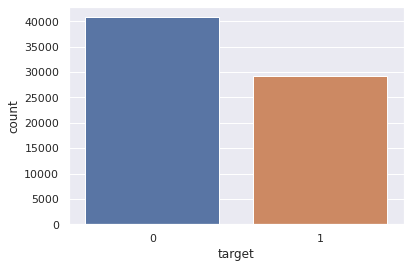

In [10]:
#Countplot
sns.set_theme(style="darkgrid")
sns.countplot(x="target", data=train_df.iloc[:70000])

In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform,start,count):
        self.ipaths = df["path"][start:count].to_numpy()
        self.target=df["target"][start:count].to_numpy()
        self.transform = transform
        self.count=count
        self.img_dir=img_dir


    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        img_path=self.img_dir+self.ipaths[idx]
        image = Image.open(img_path).convert('RGB')
        label=self.target[idx]
        image = self.transform(image)
        return image, label

In [12]:
normalizer=[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
transformations = {
		'train': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.RandomHorizontalFlip(),
			transforms.ColorJitter(brightness=0.25, contrast=0.25),
			transforms.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'val': transforms.Compose([
			transforms.Resize(256),
			transforms.CenterCrop(224),
			transforms.ToTensor(),
			transforms.Normalize(normalizer[0], normalizer[1])]),
		'test': transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize(normalizer[0], normalizer[1])])	
			}


In [13]:
train_df["target"].iloc[:43225].value_counts()

0    25160
1    18065
Name: target, dtype: int64

In [14]:
train_df["target"].iloc[43225:].value_counts()

0    25336
1    17939
Name: target, dtype: int64

In [15]:
train_df["target"].value_counts()

0    50496
1    36004
Name: target, dtype: int64

In [16]:
# train_data=CustomImageDataset(train_df,transformations["train"],0,1000)
# valid_data=CustomImageDataset(train_df,transformations["val"],1000,2000)
train_data=CustomImageDataset(train_df,'',transformations["train"],0,43225)
valid_data=CustomImageDataset(train_df,'',transformations["val"],43225,86500)
test_data=CustomImageDataset(test_df,'',transformations["test"],0,25595)
# test_data=CustomImageDataset(test_df,transformations["test"],0,20)
print(len(train_data))
print(len(test_data))
trainloader=torch.utils.data.DataLoader(train_data, batch_size=64)
valloader=torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader=torch.utils.data.DataLoader(test_data, batch_size=64)
print(trainloader)
print(len(testloader))
dataloaders = {"train":trainloader, "val":valloader, "test": testloader}
# print(len(dataloaders["train"]))
# train_data[0][0].shape

data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes

43225
25595
400


{'train': 43225, 'val': 43275, 'test': 25595}

In [17]:
import torch
torch.cuda.empty_cache()
device=torch.device("cuda:7")
print("Training on GPU... Ready for HyperJump...")

Training on GPU... Ready for HyperJump...


In [18]:
torch.cuda.set_device(gpu)

In [19]:
# num_ftrs = model.classifier.in_features
# 	model.classifier = nn.Linear(num_ftrs, numClass)

    

In [19]:
def densenet_Model(pretrained=True):
    model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    model.classifier = nn.Linear(num_ftrs, 1) # Overwrites the Classifier layer with custom defined layer for transfer learning
    model = model.to(device) # Transfer the Model to GPU if available
    return model

model = densenet_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.BCEWithLogitsLoss(reduction='mean').cuda()
# criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0001, momentum=0.9)		
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning Scheduler
exp_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 5)
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1) 



In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6954881


In [22]:
np.inf

inf

In [23]:
from sklearn.metrics import roc_auc_score
def epoch_train(model,optimizer, criterion):
    model.train()
    loss_train = 0
    loss_train_norm = 0
    loss_tensor_mean_train = 0
    output_list = []
    label_list = []
    phase="train"
    for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
        inputs = inputs.to(device, non_blocking=True)
        # labels = labels.type(torch.FloatTensor) 
        labels = labels.to(device, non_blocking=True)
        labels = labels.view(labels.size()[0],-1)

        optimizer.zero_grad()			
        outputs = model(inputs)
        # _, preds = torch.max(outputs.data, 1)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
            score = torch.sigmoid(outputs)
        else:
            score = torch.sigmoid(outputs)
        preds = score>0.5
        preds = preds.type(torch.cuda.LongTensor)
        
        labels = labels.type(torch.cuda.FloatTensor) #add for BCE loss
        loss = criterion(outputs, labels)
        loss_tensor_mean_train += loss

        labels = labels.data.cpu().numpy()
        outputs = outputs.data.cpu().numpy()

        for i in range(outputs.shape[0]):
            output_list.append(outputs[i].tolist())
            label_list.append(labels[i].tolist())

        loss_train_norm += 1
        loss.backward()
        optimizer.step()
    loss_tensor_mean_train = np.float(loss_tensor_mean_train) / loss_train_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_train, epoch_auc



In [24]:
def epoch_val(model, criterion):
    model.eval()
    loss_val = 0
    loss_val_norm = 0
    loss_tensor_mean_val = 0
    # running_corrects = 0
    output_list = []
    label_list = []
    phase='val'
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
            labels = labels.type(torch.FloatTensor) #add for BCE loss
            inputs = inputs.cuda(gpu_id, non_blocking=True)
            labels = labels.cuda(gpu_id, non_blocking=True)
            labels = labels.view(labels.size()[0],-1) #add for BCE loss

            outputs = model(inputs)
            loss_tensor = criterion(outputs, labels)
            loss_tensor_mean_val += loss_tensor
            
            labels = labels.data.cpu().numpy()
            outputs = outputs.data.cpu().numpy()

            for i in range(outputs.shape[0]):
                output_list.append(outputs[i].tolist())
                label_list.append(labels[i].tolist())
            loss_val_norm += 1
    loss_tensor_mean_val = np.float(loss_tensor_mean_val) / loss_val_norm
    epoch_auc =  roc_auc_score(np.array(label_list), np.array(output_list))
    output_list = []
    label_list = []
    return loss_tensor_mean_val, epoch_auc

    

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epoch=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    loss_min = np.inf

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-' * 10)

        loss_train, auc_train = epoch_train(model, optimizer, criterion)
        loss_val, auc_val=epoch_val(model,criterion)

        scheduler.step(loss_val)
        if loss_val < loss_min:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(loss_min, loss_val))
            loss_min=loss_val
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

        print ('*'*20)	
        print ('Train_AUC: {:.4f}     Train_loss: {:.4f}'\
            .format(auc_train, loss_train))
        print ('  Val_AUC: {:.4f}     Val_loss: {:.4f}'\
            .format(auc_val, loss_val))
        print ('\n')
    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(loss_min))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model
    
        

In [26]:
# def train_model(model, criterion, optimizer, scheduler, num_epoch=10):
#     since = time.time()
#     best_model_wts = copy.deepcopy(model.state_dict())
#     loss_min = np.inf

#     for epoch in range(num_epoch):
#         print('Epoch {}/{}'.format(epoch+1, num_epoch))
#         print('-' * 10)
#         for phase in ["train","val"]:
#             if(phase=="train"):
#                 model.train()
#             else:
#                 model.eval()
            
#             loss_norm = 0
#             loss_tensor_mean = 0
#             output_list = []
#             label_list = []
#             for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
#                 labels = labels.type(torch.FloatTensor) #add for BCE loss
#                 inputs = inputs.cuda(gpu_id, non_blocking=True)
#                 labels = labels.cuda(gpu_id, non_blocking=True)
#                 labels = labels.view(labels.size()[0],-1)

#                 if(phase=="train"):
#                     optimizer.zero_grad()
#                 outputs=model(inputs)
                

In [20]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [21]:
train_df=pd.DataFrame()
test_df=pd.DataFrame()
testloader=[]

In [22]:
torch.cuda.empty_cache()

In [30]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epoch=1)

Epoch 1/1
----------


Val loss Decreased from inf to 0.5976 
Saving Weights... 

********************
Train_AUC: 0.6957     Train_loss: 0.6214
  Val_AUC: 0.7317     Val_loss: 0.5976


Training complete in 46m 39s
Best val loss: 0.5976


In [31]:
path="/DATA/chowdari1/saved_models/nih_gold(1epoch).pth"
torch.save(base_model.state_dict(), path)

In [2]:
!nvidia-smi

Fri Nov 19 02:22:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 42%   74C    P2   238W / 250W |  10797MiB / 11178MiB |     85%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   52C    P2    58W / 250W |  11170MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [23]:
# model_path = 'path/to/model.pt'
# model = UNet(n_channels = 1, n_classes = 1)
# state_dict = torch.load(model_path,map_location='cpu')
# model.load_state_dict(state_dict)
# model.to(device)

import torch
path="/DATA/chowdari1/saved_models/nih_gold(100epoch).pth"
base_model=densenet_Model(pretrained=True)

x=torch.load(path,map_location='cpu')

base_model.load_state_dict(x)
base_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
# import torch
# path="/DATA/chowdari1/saved_models/nih_gold(100epoch).pth"
# base_model=densenet_Model(pretrained=True)
# # x=torch.load(path)

# base_model.load_state_dict(torch.load(path))

In [25]:
from sklearn import metrics
def test(model,dataloader):
	model.eval()
	running_corrects = 0
	output_list =[]
	label_list = []
	preds_list = []
	phase='test'
	with torch.no_grad():
		for inputs, labels in tqdm.tqdm(dataloader, leave=False):
			labels_auc = labels
			labels_print = labels
			labels_auc = labels_auc.type(torch.FloatTensor)
			labels = labels.type(torch.LongTensor) #add for BCE loss
			inputs = inputs.cuda(gpu_id, non_blocking=True)
			labels = labels.cuda(gpu_id, non_blocking=True)
			labels_auc = labels_auc.cuda(gpu_id, non_blocking=True)

			labels = labels.view(labels.size()[0],-1) #add for BCE loss
			labels_auc = labels_auc.view(labels_auc.size()[0],-1) #add for BCE loss
			# forward
			outputs = model(inputs)
			# _, preds = torch.max(outputs.data, 1)
			score = torch.sigmoid(outputs)
			score_np = score.data.cpu().numpy()
			preds = score>0.5
			preds_np = preds.data.cpu().numpy()
			preds = preds.type(torch.cuda.LongTensor)

			labels_auc = labels_auc.data.cpu().numpy()
			outputs = outputs.data.cpu().numpy()
			for i in range(outputs.shape[0]):
				output_list.append(outputs[i].tolist())
				label_list.append(labels_auc[i].tolist())
				preds_list.append(preds_np[i].tolist())
			# running_corrects += torch.sum(preds == labels.data)
			# labels = labels.type(torch.cuda.FloatTensor)
			running_corrects += torch.sum(preds.data == labels.data) #add for BCE loss
	data_size=len(dataloader.sampler)
	acc = np.float(running_corrects) / data_size
	auc = metrics.roc_auc_score(np.array(label_list), np.array(output_list), average=None)
	# print(auc)
	fpr, tpr, _ = metrics.roc_curve(np.array(label_list), np.array(output_list))
	roc_auc = metrics.auc(fpr, tpr)

	ap = metrics.average_precision_score(np.array(label_list), np.array(output_list))
	
	tn, fp, fn, tp = metrics.confusion_matrix(label_list, preds_list).ravel()

	recall = tp/(tp+fn)
	precision = tp/(tp+fp)
	f1 = 2*precision*recall/(precision+recall)
	sensitivity = recall
	specificity = tn/(tn+fp)
	PPV = tp/(tp+fp)
	NPV = tn/(tn+fn)
	print(classification_report(label_list,preds_list))
	print('Test Accuracy: {0:.4f}  Test AUC: {1:.4f}  Test_AP: {2:.4f}'.format(acc, auc, ap))
	print('TP: {0:}  FP: {1:}  TN: {2:}  FN: {3:}'.format(tp, fp, tn, fn))
	print('Sensitivity: {0:.4f}  Specificity: {1:.4f}'.format(sensitivity, specificity))
	print('Precision: {0:.2f}%  Recall: {1:.2f}%  F1: {2:.4f}'.format(precision*100, recall*100, f1))
	print('PPV: {0:.4f}  NPV: {1:.4f}'.format(PPV, NPV))
	# Plot all ROC curves
	plt.figure()
	plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
	plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
	plt.xlim([0.0, 1.0])
	plt.ylim([0.0, 1.0])
	plt.xlabel('False Positive Rate')
	plt.ylabel('True Positive Rate')
	plt.title('ROC curve of abnormal/normal classification: ')
	plt.legend(loc="lower right")
	# plt.savefig('ROC_abnormal_normal_cls_'+args.arch+'_'+args.test_labels+'.pdf', bbox_inches='tight')
	plt.show()

In [26]:
!nvidia-smi

Fri Nov 19 05:39:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 42%   73C    P2   191W / 250W |  10797MiB / 11178MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   52C    P2    57W / 250W |  10833MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

              precision    recall  f1-score   support

         0.0       0.64      0.50      0.56      9859
         1.0       0.72      0.82      0.77     15736

    accuracy                           0.70     25595
   macro avg       0.68      0.66      0.67     25595
weighted avg       0.69      0.70      0.69     25595

Test Accuracy: 0.6983  Test AUC: 0.7056  Test_AP: 0.7572
TP: 12925  FP: 4912  TN: 4947  FN: 2811
Sensitivity: 0.8214  Specificity: 0.5018
Precision: 72.46%  Recall: 82.14%  F1: 0.7700
PPV: 0.7246  NPV: 0.6377


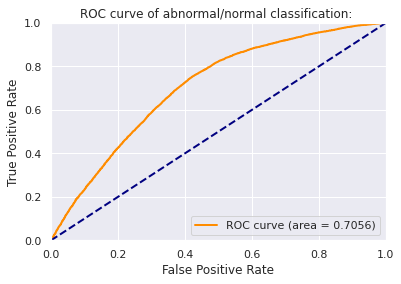

In [27]:
test(base_model,dataloaders['test'])

In [ ]:
test_data=CustomImageDataset(test_df,transformations["test"],0,25595)
testloader=torch.utils.data.DataLoader(test_data, batch_size=64)

In [79]:
df_stanford =pd.read_csv('/DATA/chowdari1/DATA/csv/good_all_stanford.csv')
df_stanford["path"]=df_stanford["Path"]

In [80]:
test_data_stanford=CustomImageDataset(df_stanford,"/DATA/chowdari1/DATA/dataset/stanford/",transformations["test"],33900+6800,452765)
print(len(test_data_stanford))
testloader_stanford=torch.utils.data.DataLoader(test_data_stanford, batch_size=64)
print(len(testloader_stanford))


4576
72


In [75]:
for x in testloader_stanford:
    print('no')
    break

no


In [59]:
data_sizes =  len(testloader_stanford.sampler)
# data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val','test']}
data_sizes

4576

In [76]:
for inputs, labels in tqdm.tqdm(testloader_stanford, leave=False):
    print('yes')
    break


yes


Test Accuracy: 0.5356  Test AUC: 0.8266  Test_AP: 0.6378
TP: 1254  FP: 2071  TN: 1197  FN: 54
Sensitivity: 0.9587  Specificity: 0.3663
Precision: 37.71%  Recall: 95.87%  F1: 0.5413
PPV: 0.3771  NPV: 0.9568


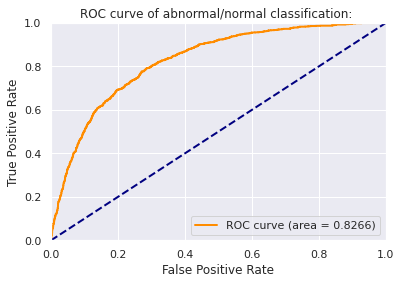

In [81]:
test(base_model,testloader_stanford)